# Working with Missing Data: Car Accidents in New York

Corresponds to a DataQuest session.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from pathlib import Path

In [2]:
data_path = Path.home() / "datasets" / "tabular_practice"
mvc = pd.read_csv(data_path / "nypd_mvc_2018.csv")
mvc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57864 entries, 0 to 57863
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   unique_key           57864 non-null  int64  
 1   date                 57864 non-null  object 
 2   time                 57864 non-null  object 
 3   borough              37218 non-null  object 
 4   location             53979 non-null  object 
 5   on_street            43903 non-null  object 
 6   cross_street         28615 non-null  object 
 7   off_street           13771 non-null  object 
 8   pedestrians_injured  57864 non-null  int64  
 9   cyclist_injured      57864 non-null  int64  
 10  motorist_injured     57864 non-null  int64  
 11  total_injured        57863 non-null  float64
 12  pedestrians_killed   57864 non-null  int64  
 13  cyclist_killed       57864 non-null  int64  
 14  motorist_killed      57864 non-null  int64  
 15  total_killed         57859 non-null 

For the columns "pedestrians_injured" until "total_killed", only "total_injured" and "total_killed" have few missing values. But these should just be derived from the others.

In [3]:
(mvc.iloc[:, 8:11].sum(axis=1) == mvc["total_injured"]).sum()

57842

In [4]:
subjects = ["pedestrians", "cyclist", "motorist", "total"]
for postfix in ["_injured", "_killed"]:
    names = [x + postfix for x in subjects]
    print(mvc.loc[mvc.loc[:, names[:-1]].sum(axis=1) != mvc[names[-1]], names])

       pedestrians_injured  cyclist_injured  motorist_injured  total_injured
1222                     0                0                 1            0.0
3263                     0                0                 3            4.0
3362                     0                0                 0            1.0
3508                     0                0                 0            2.0
10989                    0                0                 0            1.0
12885                    1                0                 0            0.0
13344                    0                0                 0            1.0
15213                    0                0                 0            2.0
20163                    0                0                 0            1.0
20978                    0                0                 0            1.0
23276                    0                0                 1            0.0
24907                    1                0                 0            0.0

We see that only for a small percentage of rows, the "total" columns do not contain the sum of the other columns respectively, either because they contain `NaN` or a wrong number. We'll replace `NaN` values with the correct sum, but then replace wrong numbers in "total" with `NaN.

In [5]:
# Fix values
subjects = ["pedestrians", "cyclist", "motorist", "total"]
for postfix in ["_injured", "_killed"]:
    names = [x + postfix for x in subjects]
    sum_cols = mvc[names[:-1]].sum(axis=1)
    neq_ind = sum_cols != mvc[names[-1]]
    nz_ind = mvc[names[-1]].notnull()
    mvc[names[-1]] = sum_cols
    mvc.loc[neq_ind & nz_ind, names[-1]] = np.nan

In [6]:
mvc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57864 entries, 0 to 57863
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   unique_key           57864 non-null  int64  
 1   date                 57864 non-null  object 
 2   time                 57864 non-null  object 
 3   borough              37218 non-null  object 
 4   location             53979 non-null  object 
 5   on_street            43903 non-null  object 
 6   cross_street         28615 non-null  object 
 7   off_street           13771 non-null  object 
 8   pedestrians_injured  57864 non-null  int64  
 9   cyclist_injured      57864 non-null  int64  
 10  motorist_injured     57864 non-null  int64  
 11  total_injured        57843 non-null  float64
 12  pedestrians_killed   57864 non-null  int64  
 13  cyclist_killed       57864 non-null  int64  
 14  motorist_killed      57864 non-null  int64  
 15  total_killed         57863 non-null 

The remaining columns of concern are: "borough", "location", "on_street", "cross_street", "off_street".

In [7]:
import seaborn as sns

def plot_null_correlations(df):
    # create a correlation matrix only for columns with at least
    # one missing value
    cols_with_missing_vals = df.columns[df.isnull().sum() > 0]
    missing_corr = df[cols_with_missing_vals].isnull().corr()
    
    # create a mask to avoid repeated values and make
    # the plot easier to read
    missing_corr = missing_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(missing_corr), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()

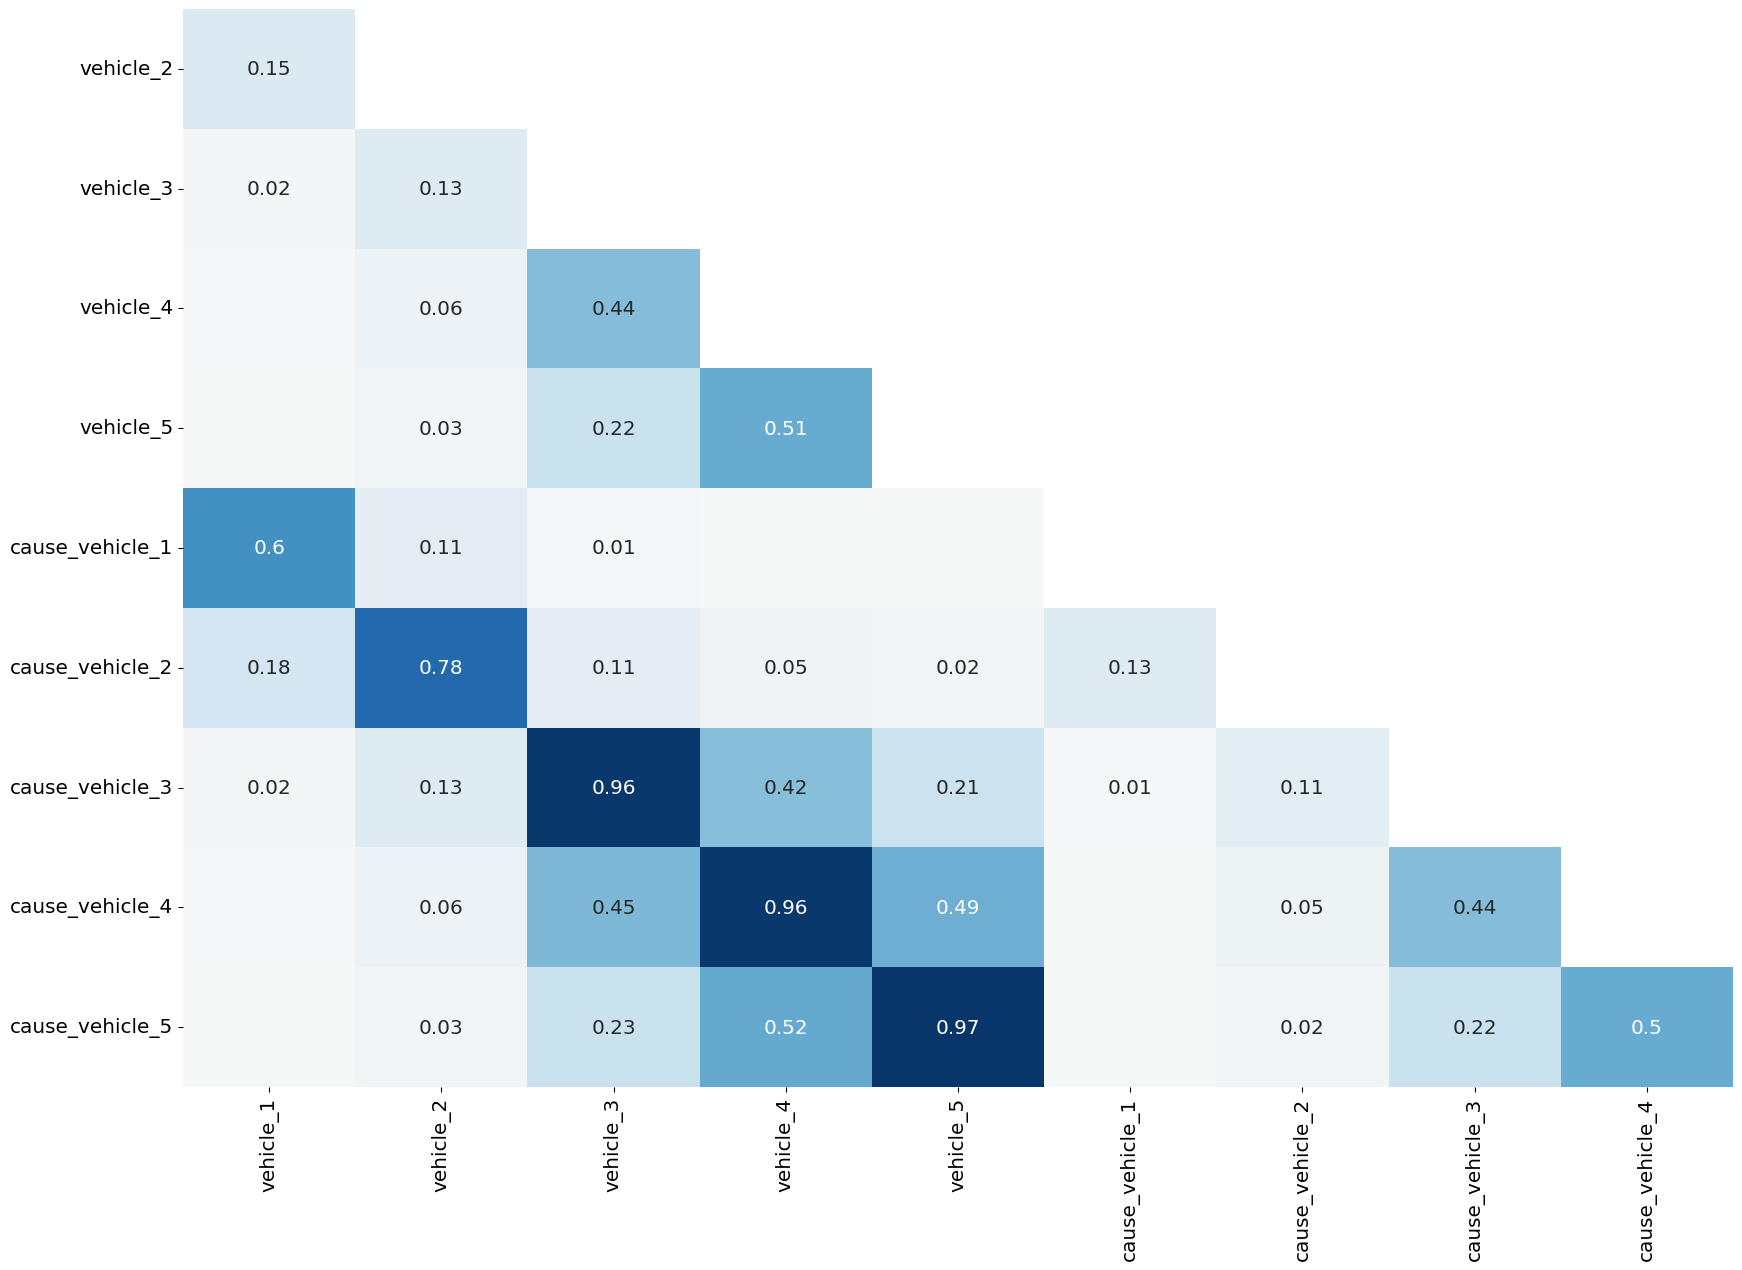

In [8]:
plot_null_correlations(mvc[mvc.columns[mvc.columns.str.contains("vehicle")]])

From this correlation plot, we see that the non-zero pattern between "vehicle_?" and "cause_vehicle_?" is strongly correlated.

In [9]:
mvc_part = mvc[[f"vehicle_{i}" for i in range(1, 6)]]

row_map = {
    tuple([False] * i + [True] * (5 - i)): i for i in range(6)
}

def classify(row):
    return row_map.get(tuple(row.isnull()))

df = mvc_part.apply(classify, axis=1)
df.value_counts(dropna=False)

2    42090
1    11907
3     2806
4      523
0      355
5      183
Name: count, dtype: int64

In [10]:
mvc_part = mvc[[f"cause_vehicle_{i}" for i in range(1, 6)]]

row_map = {
    tuple([False] * i + [True] * (5 - i)): i for i in range(6)
}

def classify(row):
    return row_map.get(tuple(row.isnull()))

df = mvc_part.apply(classify, axis=1)
df.value_counts(dropna=False)

2    45442
1     8517
3     2977
4      560
5      193
0      175
Name: count, dtype: int64

We see that for columns "vehicle_?" and "cause_vehicle_?", `NaN` plays a particular role, in that they really encode lists of between 0 and 5 values.

Let us first check for how many rows the non-zero patterns of "vehicle_?" and "cause_vehicle_?" differ, if at all.

In [11]:
col_labels = ['v_number', 'vehicle_missing', 'cause_missing']

def summarize_missing():
    vc_null_data = []
    for v in range(1,6):
        v_col = 'vehicle_{}'.format(v)
        c_col = 'cause_vehicle_{}'.format(v)
        v_null = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
        c_null = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()
        vc_null_data.append([v, v_null, c_null])
    return pd.DataFrame(vc_null_data, columns=col_labels)

vc_null_df = summarize_missing()
vc_null_df

,v_number,vehicle_missing,cause_missing
0,1,204,24
1,2,3793,223
2,3,242,24
3,4,50,3
4,5,10,0


In [12]:
vc_null_df[col_labels[1:]].sum(axis=1).sum()

4573

There are 4573 missing values across the 10 columns which have nothing to do with the structure. Let us impute these missing values, by using the most frequent values respectively.

In [13]:
v_names = mvc.columns[mvc.columns.str.startswith("vehicle_")]
v_series = mvc[v_names].stack()
v_series

0      vehicle_1                      PASSENGER VEHICLE
1      vehicle_1          SPORT UTILITY / STATION WAGON
       vehicle_2                                     DS
2      vehicle_1    Station Wagon/Sport Utility Vehicle
       vehicle_2                                  Sedan
                                   ...                 
57862  vehicle_1                                  Sedan
       vehicle_2                   Tractor Truck Diesel
       vehicle_3    Station Wagon/Sport Utility Vehicle
57863  vehicle_1                          Pick-up Truck
       vehicle_2    Station Wagon/Sport Utility Vehicle
Length: 107512, dtype: object

In [14]:
v_series.value_counts()

Sedan                                  33133
Station Wagon/Sport Utility Vehicle    26124
PASSENGER VEHICLE                      16026
SPORT UTILITY / STATION WAGON          12356
Taxi                                    3482
                                       ...  
semi                                       1
NEW Y                                      1
Chevr                                      1
self                                       1
TANKE                                      1
Name: count, Length: 326, dtype: int64

In [15]:
c_names = mvc.columns[mvc.columns.str.startswith("cause_vehicle_")]
c_series = mvc[c_names].stack()
c_series.value_counts()

Unspecified                                              57481
Driver Inattention/Distraction                           17650
Following Too Closely                                     6567
Failure to Yield Right-of-Way                             4566
Passing or Lane Usage Improper                            3260
Passing Too Closely                                       3045
Backing Unsafely                                          3001
Other Vehicular                                           2523
Unsafe Lane Changing                                      2372
Turning Improperly                                        1590
Reaction to Uninvolved Vehicle                            1206
Traffic Control Disregarded                               1205
Driver Inexperience                                       1086
Unsafe Speed                                               995
Pavement Slippery                                          755
Alcohol Involvement                                    

In [16]:
# We can use the "Unspecified" string for both missing "vehicle" and "cause_vehicle" values.

for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    mvc.loc[mvc[v_col].isnull() & mvc[c_col].notnull(), v_col] = "Unspecified"
    mvc.loc[mvc[c_col].isnull() & mvc[v_col].notnull(), c_col] = "Unspecified"

summarize_missing()

,v_number,vehicle_missing,cause_missing
0,1,0,0
1,2,0,0
2,3,0,0
3,4,0,0
4,5,0,0


In [17]:
mvc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57864 entries, 0 to 57863
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   unique_key           57864 non-null  int64  
 1   date                 57864 non-null  object 
 2   time                 57864 non-null  object 
 3   borough              37218 non-null  object 
 4   location             53979 non-null  object 
 5   on_street            43903 non-null  object 
 6   cross_street         28615 non-null  object 
 7   off_street           13771 non-null  object 
 8   pedestrians_injured  57864 non-null  int64  
 9   cyclist_injured      57864 non-null  int64  
 10  motorist_injured     57864 non-null  int64  
 11  total_injured        57843 non-null  float64
 12  pedestrians_killed   57864 non-null  int64  
 13  cyclist_killed       57864 non-null  int64  
 14  motorist_killed      57864 non-null  int64  
 15  total_killed         57863 non-null 

In [18]:
loc_cols = ['borough', 'location', 'on_street', 'off_street', 'cross_street']
location_data = mvc[loc_cols]
location_data.head()

,borough,location,on_street,off_street,cross_street
0,MANHATTAN,"(40.742832, -74.00771)",WEST 15 STREET,NaN,10 AVENUE
1,BROOKLYN,"(40.623714, -73.99314)",16 AVENUE,NaN,62 STREET
2,NaN,"(40.591755, -73.9083)",BELT PARKWAY,NaN,NaN
3,QUEENS,"(40.73602, -73.87954)",GRAND AVENUE,NaN,VANLOON STREET
4,BRONX,"(40.884727, -73.89945)",NaN,208 WEST 238 STREET,NaN


In [19]:
location_data.isnull().sum()

borough         20646
location         3885
on_street       13961
off_street      44093
cross_street    29249
dtype: int64

All of these columns describe the location of the accident. We should be able to impute missing values by using additional information.

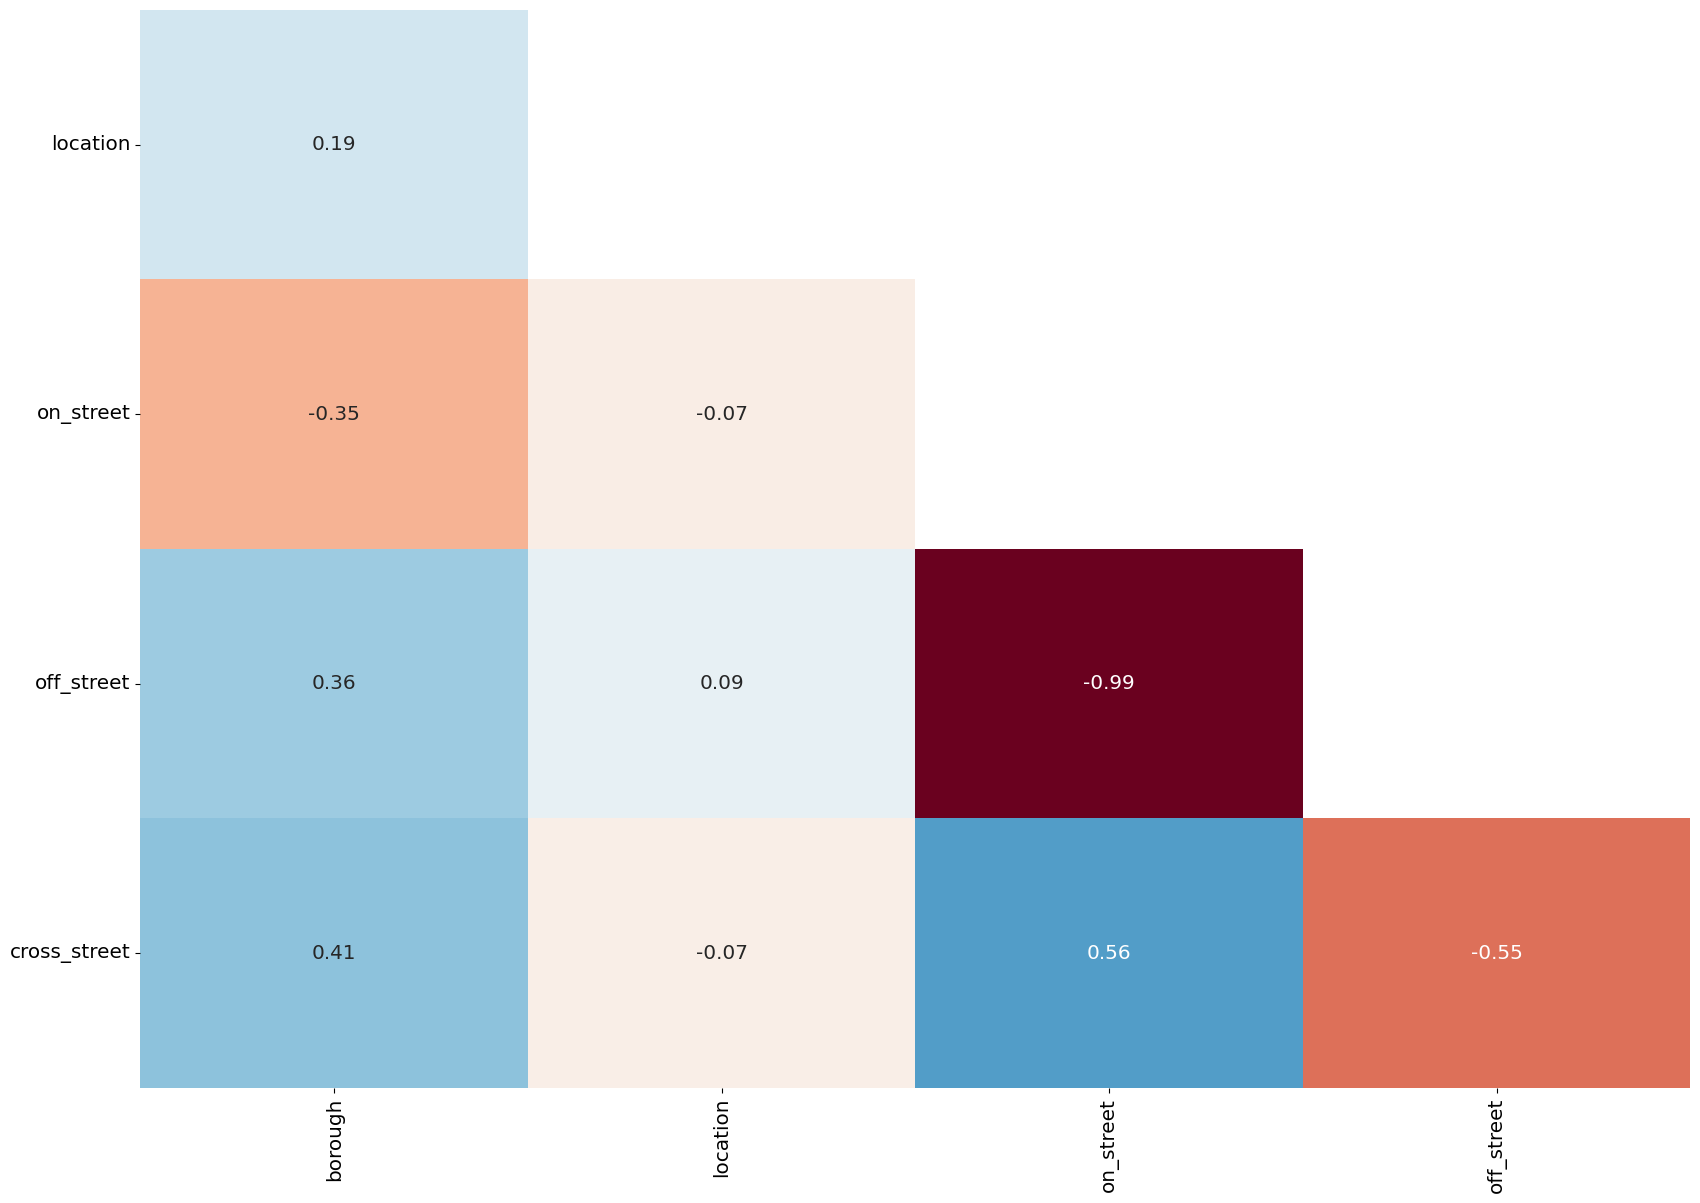

In [20]:
plot_null_correlations(location_data)

In [21]:
(location_data["on_street"].isnull() & location_data["off_street"].isnull()).sum()

190

In [22]:
(location_data["on_street"].notnull() & location_data["off_street"].notnull()).sum()

0

In [23]:
def plot_null_matrix(df, figsize=(18,15)):
    # initiate the figure
    plt.figure(figsize=figsize)
    # create a boolean dataframe based on whether values are null
    df_null = df.isnull()
    # create a heatmap of the boolean dataframe
    sns.heatmap(~df_null, cbar=False, yticklabels=False)
    plt.xticks(rotation=90, size='x-large')
    plt.show()

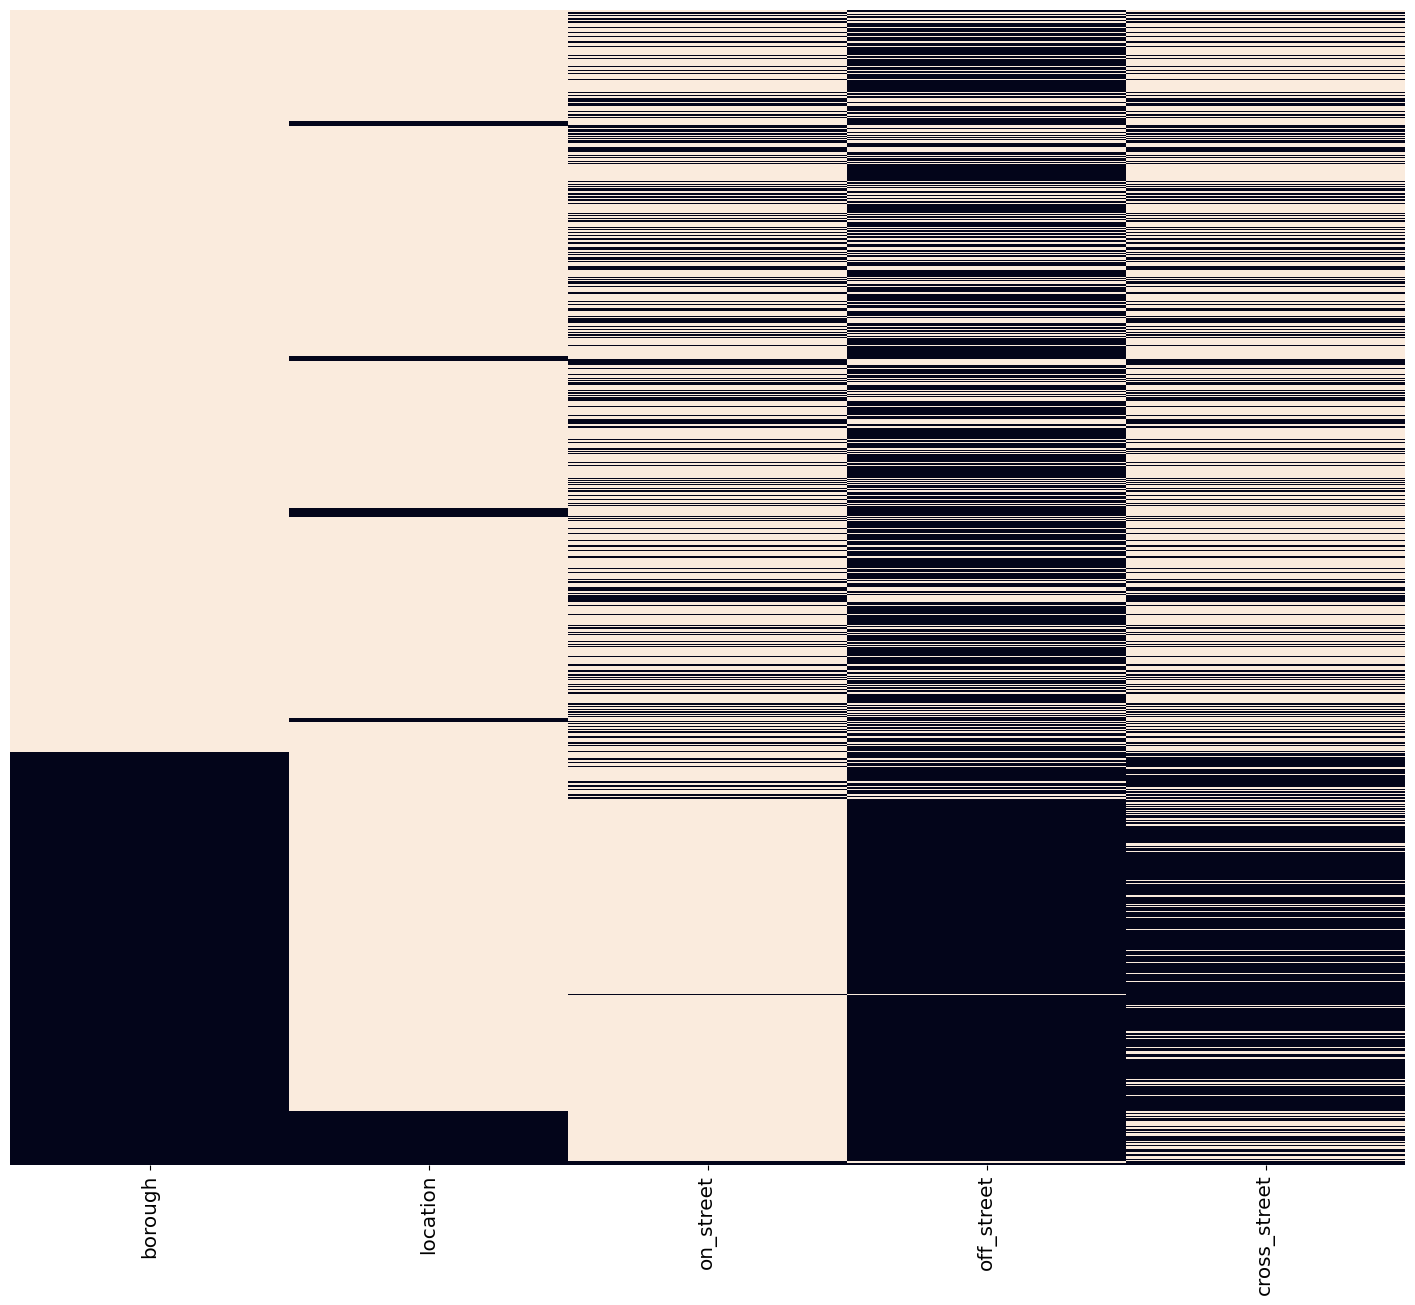

In [24]:
# Let us visualize the pattern of missing values. Sorting the dataframe first makes sure that equal values are next to each other in rows

plot_null_matrix(location_data.sort_values(loc_cols))

We see that:

* Most missing "borough" values can be inferred from "location" values
* For most missing "location" values, we have at least one of the street values

This means we can use extra geolocation data in order to impute missing values.

At this point, we could use a geolocation service, such as `Nominatim`, in order to query missing values. If we query the address for "location", we can fill in "borough" and "off_street" from the address.

However, the terms of service of `Nominatim` strongly discourages bulk requests, and we'd need 41129 requests!

For practice, we wrote some code for this, in the `scripts` subdirectory.

Instead, we just use the data provided by DataQuest.

In [25]:
sup_data = pd.read_csv(data_path / "supplemental_data.csv")
sup_data.head(10)

,unique_key,location,on_street,off_street,borough
0,3869058,NaN,NaN,NaN,NaN
1,3847947,NaN,NaN,NaN,NaN
2,3914294,NaN,BELT PARKWAY,NaN,BROOKLYN
3,3915069,NaN,NaN,NaN,NaN
4,3923123,NaN,NaN,NaN,NaN
5,3987177,NaN,NaN,1115 5TH AVENUE,MANHATTAN
6,4008417,NaN,NaN,NaN,NaN
7,3917518,NaN,NaN,806 3RD AVENUE,BROOKLYN
8,3953286,NaN,NaN,NaN,NaN
9,3896388,NaN,NaN,NaN,NaN


We want to copy all non-null values from `sup_data` over to `mvc`. First, we join the two. Then, we do the copying column by column.

In [26]:
mvc_imputed = mvc.merge(sup_data, how="left", on="unique_key", suffixes=(None, "_y"))
mvc_imputed.head(10)

,unique_key,date,time,borough,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,...,vehicle_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5,location_y,on_street_y,off_street_y,borough_y
0,3869058,2018-03-23,21:40,MANHATTAN,"(40.742832, -74.00771)",WEST 15 STREET,10 AVENUE,NaN,0,0,...,NaN,Following Too Closely,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3847947,2018-02-13,14:45,BROOKLYN,"(40.623714, -73.99314)",16 AVENUE,62 STREET,NaN,0,0,...,NaN,Backing Unsafely,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3914294,2018-06-04,0:00,NaN,"(40.591755, -73.9083)",BELT PARKWAY,NaN,NaN,0,0,...,NaN,Following Too Closely,Unspecified,NaN,NaN,NaN,NaN,BELT PARKWAY,NaN,BROOKLYN
3,3915069,2018-06-05,6:36,QUEENS,"(40.73602, -73.87954)",GRAND AVENUE,VANLOON STREET,NaN,0,0,...,NaN,Glare,Passing Too Closely,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3923123,2018-06-16,15:45,BRONX,"(40.884727, -73.89945)",NaN,NaN,208 WEST 238 STREET,0,0,...,NaN,Turning Improperly,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3987177,2018-09-14,11:50,NaN,"(40.785984, -73.95718)",EAST 93 STREET,NaN,NaN,0,0,...,NaN,Driver Inattention/Distraction,Passing Too Closely,NaN,NaN,NaN,NaN,NaN,1115 5TH AVENUE,MANHATTAN
6,4008417,2018-10-19,11:00,QUEENS,"(40.731968, -73.923225)",54 AVENUE,44 STREET,NaN,0,0,...,NaN,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3917518,2018-06-05,10:00,NaN,"(40.660114, -74.00191)",3 AVENUE,NaN,NaN,0,0,...,NaN,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,806 3RD AVENUE,BROOKLYN
8,3953286,2018-08-03,22:30,QUEENS,"(40.666393, -73.75177)",NORTH CONDUIT AVENUE,225 STREET,NaN,0,0,...,NaN,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3896388,2018-05-08,8:40,QUEENS,"(40.715763, -73.737755)",218 STREET,99 AVENUE,NaN,0,0,...,NaN,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
for name in loc_cols[:-1]:
    right_name = name + "_y"
    nz_ind = mvc_imputed[right_name].notnull()
    mvc_imputed.loc[nz_ind, name] = mvc_imputed.loc[nz_ind, right_name]

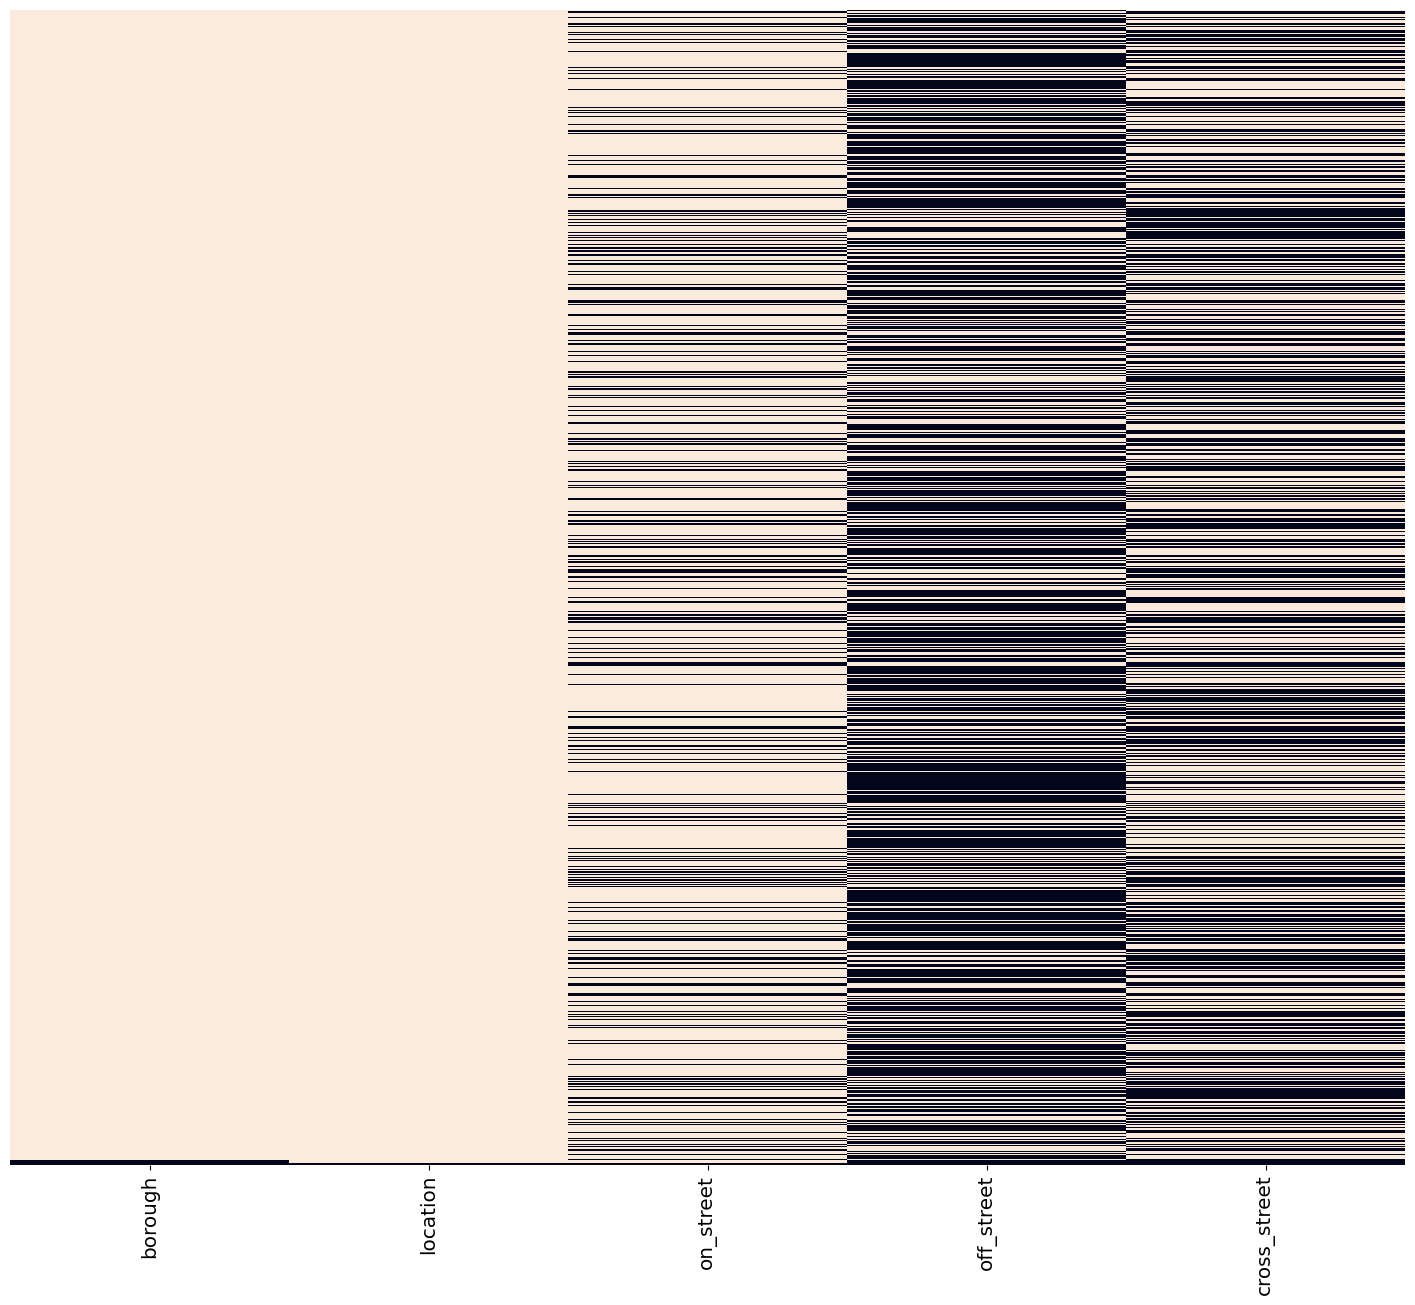

In [28]:
location_data_new = mvc_imputed[loc_cols]
plot_null_matrix(location_data_new.sort_values(loc_cols))

In [29]:
location_data_new.isnull().sum()

borough           232
location           77
on_street       13734
off_street      36131
cross_street    29249
dtype: int64

In [30]:
location_data.isnull().sum()

borough         20646
location         3885
on_street       13961
off_street      44093
cross_street    29249
dtype: int64

We managed to impute most missing values for "borough" and "location" (the latter is using a non-missing street name to infer the location), moreover almost 8000 "off_street" values and more than 200 "on_street" values.

**Note**: Comparing the two null matrix plots, it looks like values of "on_street" have been lost. But this is just an artefact of the sort ordering of rows being different.

In [31]:
mvc = mvc_imputed

Let us finally clean up the values in "vehicle_*", which may contain duplicates. First, we convert everything to upper case.

In [32]:
v_names = mvc.columns[mvc.columns.str.startswith("vehicle_")]
v_series = mvc[v_names].stack()

In [33]:
v_hist = v_series.value_counts()
v_hist.shape

(327,)

In [34]:
v_hist.head(50)

Sedan                                  33133
Station Wagon/Sport Utility Vehicle    26124
PASSENGER VEHICLE                      16026
SPORT UTILITY / STATION WAGON          12356
Unspecified                             4299
Taxi                                    3482
Pick-up Truck                           2373
TAXI                                    1892
Box Truck                               1659
Bike                                    1190
Bus                                     1162
PICK-UP TRUCK                           1144
TK                                       797
Tractor Truck Diesel                     626
BU                                       601
Van                                      544
Motorcycle                               448
BICYCLE                                  338
DS                                       281
Dump                                     245
Convertible                              217
VN                                       197
Flat Bed  

In [35]:
v_upper_hist = v_series.str.upper().value_counts()
v_upper_hist.shape

(245,)

In [36]:
v_upper_hist.head(30)

SEDAN                                  33133
STATION WAGON/SPORT UTILITY VEHICLE    26124
PASSENGER VEHICLE                      16026
SPORT UTILITY / STATION WAGON          12356
TAXI                                    5375
UNSPECIFIED                             4299
PICK-UP TRUCK                           3517
BOX TRUCK                               1659
BIKE                                    1190
BUS                                     1170
TK                                       798
TRACTOR TRUCK DIESEL                     626
VAN                                      609
BU                                       601
MOTORCYCLE                               521
BICYCLE                                  338
DS                                       281
DUMP                                     252
CONVERTIBLE                              217
VN                                       197
FLAT BED                                 169
PK                                       164
GARBAGE OR

We could go on and map two-letter values to longer names ("BU" -> "BUS", "VN" -> "VAN", ...), but this is too tedious.

In [37]:
for name in v_names:
    mvc[name] = mvc[name].str.upper()    

## Visualization of Accident Locations

Finally, we could try to visualize the accident locations on a map of New York. Maybe this helps:

https://stackoverflow.com/questions/66498316/plotting-locations-on-a-nyc-map-using-geopandas-and-geoplot

In [38]:
import geopandas
import geoplot
from shapely.geometry import Point, Polygon

In [39]:
mvc_plot = mvc.copy()
long_lat = mvc_plot["location"].str.strip().str[1:-1].str.split(",")
mvc_plot["latitude"] = long_lat.str[0].astype(float)
mvc_plot["longitude"] = long_lat.str[1].astype(float)
mvc_plot.head(10)

,unique_key,date,time,borough,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,...,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5,location_y,on_street_y,off_street_y,borough_y,latitude,longitude
0,3869058,2018-03-23,21:40,MANHATTAN,"(40.742832, -74.00771)",WEST 15 STREET,10 AVENUE,NaN,0,0,...,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.742832,-74.007710
1,3847947,2018-02-13,14:45,BROOKLYN,"(40.623714, -73.99314)",16 AVENUE,62 STREET,NaN,0,0,...,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.623714,-73.993140
2,3914294,2018-06-04,0:00,BROOKLYN,"(40.591755, -73.9083)",BELT PARKWAY,NaN,NaN,0,0,...,Unspecified,NaN,NaN,NaN,NaN,BELT PARKWAY,NaN,BROOKLYN,40.591755,-73.908300
3,3915069,2018-06-05,6:36,QUEENS,"(40.73602, -73.87954)",GRAND AVENUE,VANLOON STREET,NaN,0,0,...,Passing Too Closely,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.736020,-73.879540
4,3923123,2018-06-16,15:45,BRONX,"(40.884727, -73.89945)",NaN,NaN,208 WEST 238 STREET,0,0,...,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.884727,-73.899450
5,3987177,2018-09-14,11:50,MANHATTAN,"(40.785984, -73.95718)",EAST 93 STREET,NaN,1115 5TH AVENUE,0,0,...,Passing Too Closely,NaN,NaN,NaN,NaN,NaN,1115 5TH AVENUE,MANHATTAN,40.785984,-73.957180
6,4008417,2018-10-19,11:00,QUEENS,"(40.731968, -73.923225)",54 AVENUE,44 STREET,NaN,0,0,...,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.731968,-73.923225
7,3917518,2018-06-05,10:00,BROOKLYN,"(40.660114, -74.00191)",3 AVENUE,NaN,806 3RD AVENUE,0,0,...,Unspecified,NaN,NaN,NaN,NaN,NaN,806 3RD AVENUE,BROOKLYN,40.660114,-74.001910
8,3953286,2018-08-03,22:30,QUEENS,"(40.666393, -73.75177)",NORTH CONDUIT AVENUE,225 STREET,NaN,0,0,...,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.666393,-73.751770
9,3896388,2018-05-08,8:40,QUEENS,"(40.715763, -73.737755)",218 STREET,99 AVENUE,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.715763,-73.737755


In [40]:
mvc_plot[["latitude", "longitude"]].agg(["min", "max"])

,latitude,longitude
min,36.878013,-201.237060
max,41.274685,-32.768513


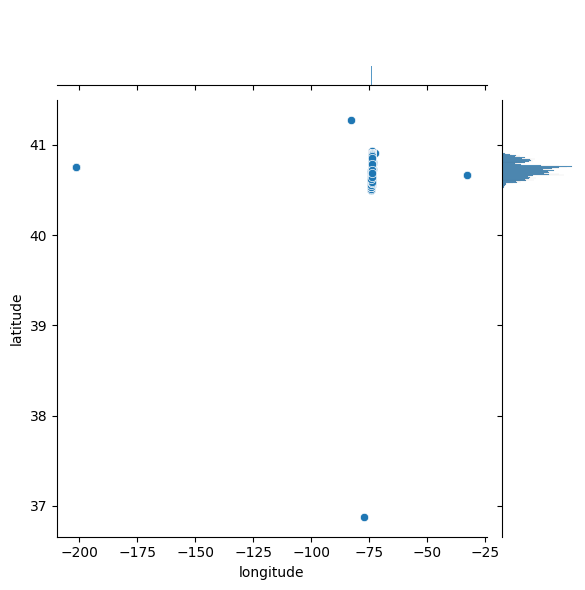

In [41]:
sns.jointplot(data=mvc_plot, x="longitude", y="latitude")

There seem to be some outliers in the data, with locations not in New York boroughs at all!

In [42]:
longitude = mvc_plot["longitude"]
long_out_ind = (longitude > -73.68) | (longitude < -74.3)
mvc_plot[long_out_ind]

,unique_key,date,time,borough,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,...,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5,location_y,on_street_y,off_street_y,borough_y,latitude,longitude
557,3870246,2018-03-25,11:00,NaN,"(40.75837, -201.23706)",QUEENSBORO BRIDGE UPPER ROADWAY,NaN,NaN,0,0,...,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.758370,-201.237060
833,3900531,2018-05-11,7:05,NaN,"(40.75837, -201.23706)",QUEENSBORO BRIDGE UPPER ROADWAY,NaN,NaN,0,0,...,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,40.758370,-201.237060
5476,3926777,2018-06-21,2:00,NaN,"(36.8780134, -77.40371449999999)",INTERSTATE ROUTE 95 EAST,PELHAM PARKWAY,NaN,0,0,...,NaN,NaN,NaN,NaN,"(36.8780134, -77.40371449999999)",NaN,NaN,NaN,36.878013,-77.403714
10933,3931723,2018-06-30,0:12,NaN,"(40.8027963, -73.31660459999999)",LONG ISLAND EXPRESSWAY,UTOPIA PARKWAY,NaN,0,0,...,Unspecified,NaN,NaN,NaN,"(40.8027963, -73.31660459999999)",NaN,NaN,NaN,40.802796,-73.316605
11464,3832438,2018-01-19,16:32,NaN,"(40.75837, -201.23706)",QUEENSBORO BRIDGE UPPER ROADWAY,NaN,NaN,0,0,...,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.758370,-201.237060
30538,3968897,2018-08-27,8:00,NaN,"(40.665226, -32.768513)",NASSAU EXPRESSWAY,NaN,NaN,0,0,...,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.665226,-32.768513
31830,3922984,2018-06-14,9:50,NaN,"(40.75837, -201.23706)",QUEENSBORO BRIDGE UPPER ROADWAY,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.758370,-201.237060
31931,3965268,2018-08-20,10:00,NaN,"(40.75837, -201.23706)",QUEENSBORO BRIDGE UPPER ROADWAY,NaN,NaN,0,0,...,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.758370,-201.237060
33795,3965478,2018-08-20,20:30,NaN,"(40.9095873, -72.6371491)",HEMPSTEAD TURNPIKE,ROUTE 9 EXTENSION WEST,NaN,0,0,...,Passing or Lane Usage Improper,NaN,NaN,NaN,"(40.9095873, -72.6371491)",NaN,NaN,NaN,40.909587,-72.637149
34623,3842802,2018-02-08,23:30,NaN,"(40.7361654, -73.3403812)",CROSS ISLAND PARKWAY,SOUTHERN STATE PARKWAY,NaN,0,0,...,NaN,NaN,NaN,NaN,"(40.7361654, -73.3403812)",NaN,NaN,NaN,40.736165,-73.340381


In [43]:
latitude = mvc_plot["latitude"]
lat_out_ind = (latitude > 40.95) | (latitude < 40.48)
mvc_plot[lat_out_ind]

,unique_key,date,time,borough,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,...,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5,location_y,on_street_y,off_street_y,borough_y,latitude,longitude
5476,3926777,2018-06-21,2:00,NaN,"(36.8780134, -77.40371449999999)",INTERSTATE ROUTE 95 EAST,PELHAM PARKWAY,NaN,0,0,...,NaN,NaN,NaN,NaN,"(36.8780134, -77.40371449999999)",NaN,NaN,NaN,36.878013,-77.403714
36829,4028169,2018-11-17,20:30,MANHATTAN,"(41.274685, -82.854355)",141 STREET,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,"(41.274685, -82.854355)",NaN,NaN,MANHATTAN,41.274685,-82.854355


Let us remove these 25 rows, in order to allow for a correct visualization.

In [44]:
mvc_plot = mvc_plot[~(long_out_ind | lat_out_ind)]
mvc_plot.shape

(57841, 32)

We can visualize in which accidents cyclists have been injured.

In [53]:
crs={'init':'epsg:4326'}

boroughs = geopandas.read_file(geoplot.datasets.get_path('nyc_boroughs'))

geo_df=geopandas.GeoDataFrame(
    mvc_plot,
    crs=crs,
    geometry=geopandas.points_from_xy(mvc_plot["longitude"], mvc_plot["latitude"])
)

/Users/seeger/venvs/datasci/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [54]:
name = "cyclist_injured"
injured_hist = mvc_plot[name].value_counts().to_dict()
injured_hist

{0: 56679, 1: 1150, 2: 12}

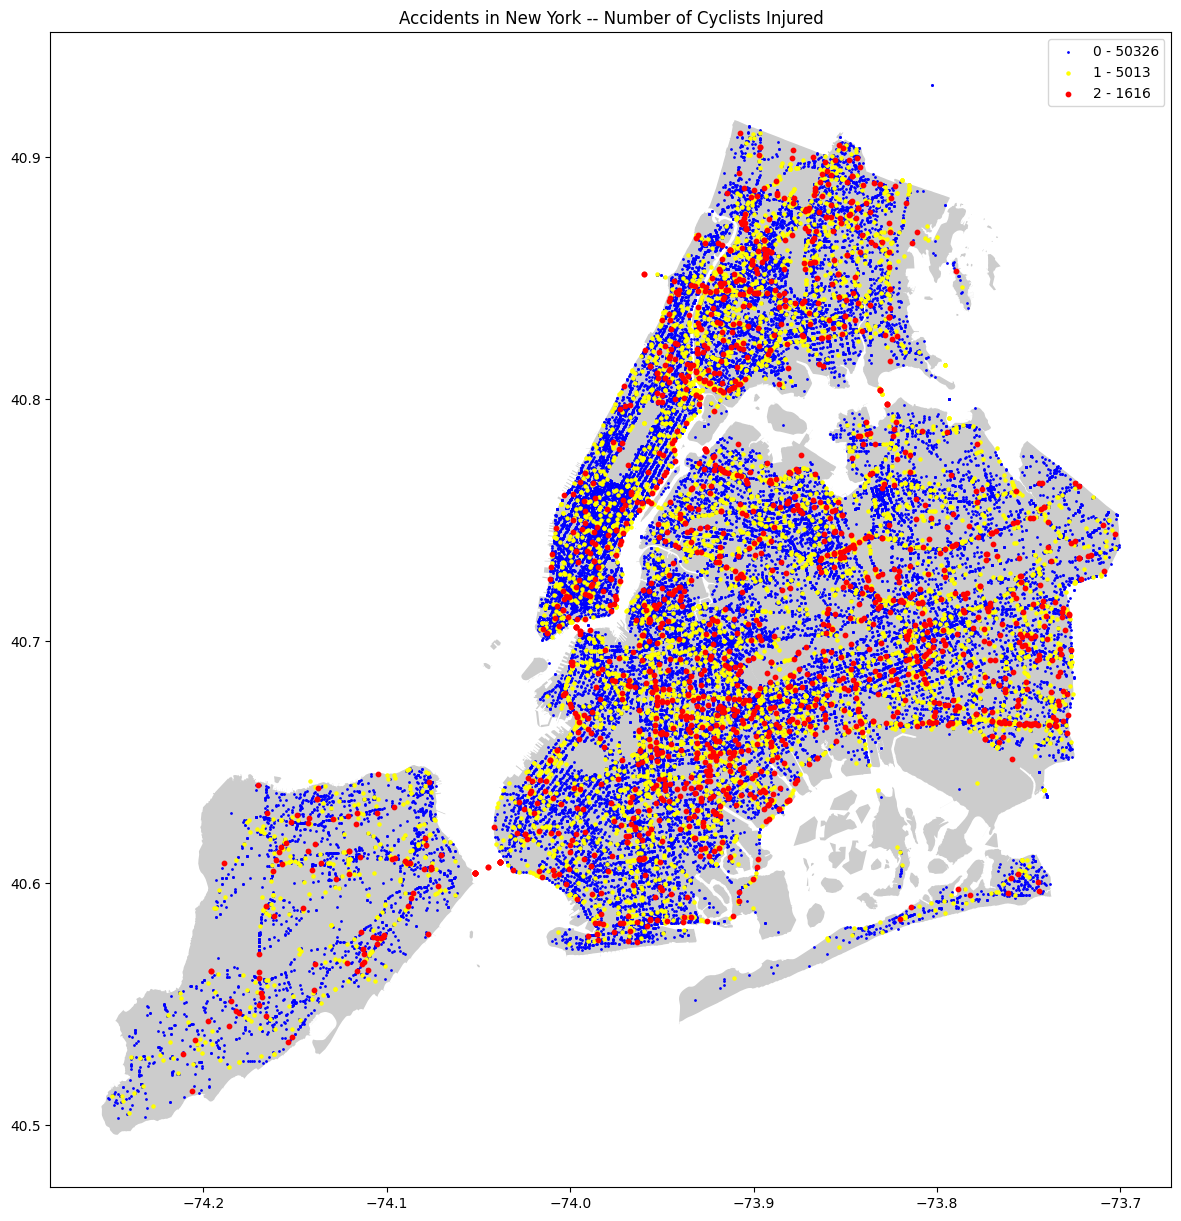

In [61]:
fig, ax = plt.subplots(figsize=(15,15))
boroughs.plot(ax=ax, alpha=0.4, color="grey")
# This plots accidents with different "cyclist_injured" values in different colors, but using the same marker size
# geo_df.plot(ax=ax, markersize=1, column=name, legend=True, categorical=True)
c_inj = geo_df[name]
for val, ms, color in [
    (0, 1, "blue"), (1, 5, "yellow"), (2, 10, "red")
]:
    label = f"{val} - {injured_hist[val]}"
    geo_df[c_inj == val].plot(ax=ax, markersize=ms, color=color, label=label)
ax.set_title("Accidents in New York -- Number of Cyclists Injured")
plt.legend()

Next, we look at the number of pedestrians injured.

In [56]:
name = "pedestrians_injured"
injured_hist = mvc_plot[name].value_counts().to_dict()
injured_hist

{0: 55237, 1: 2511, 2: 84, 3: 6, 4: 2, 6: 1}

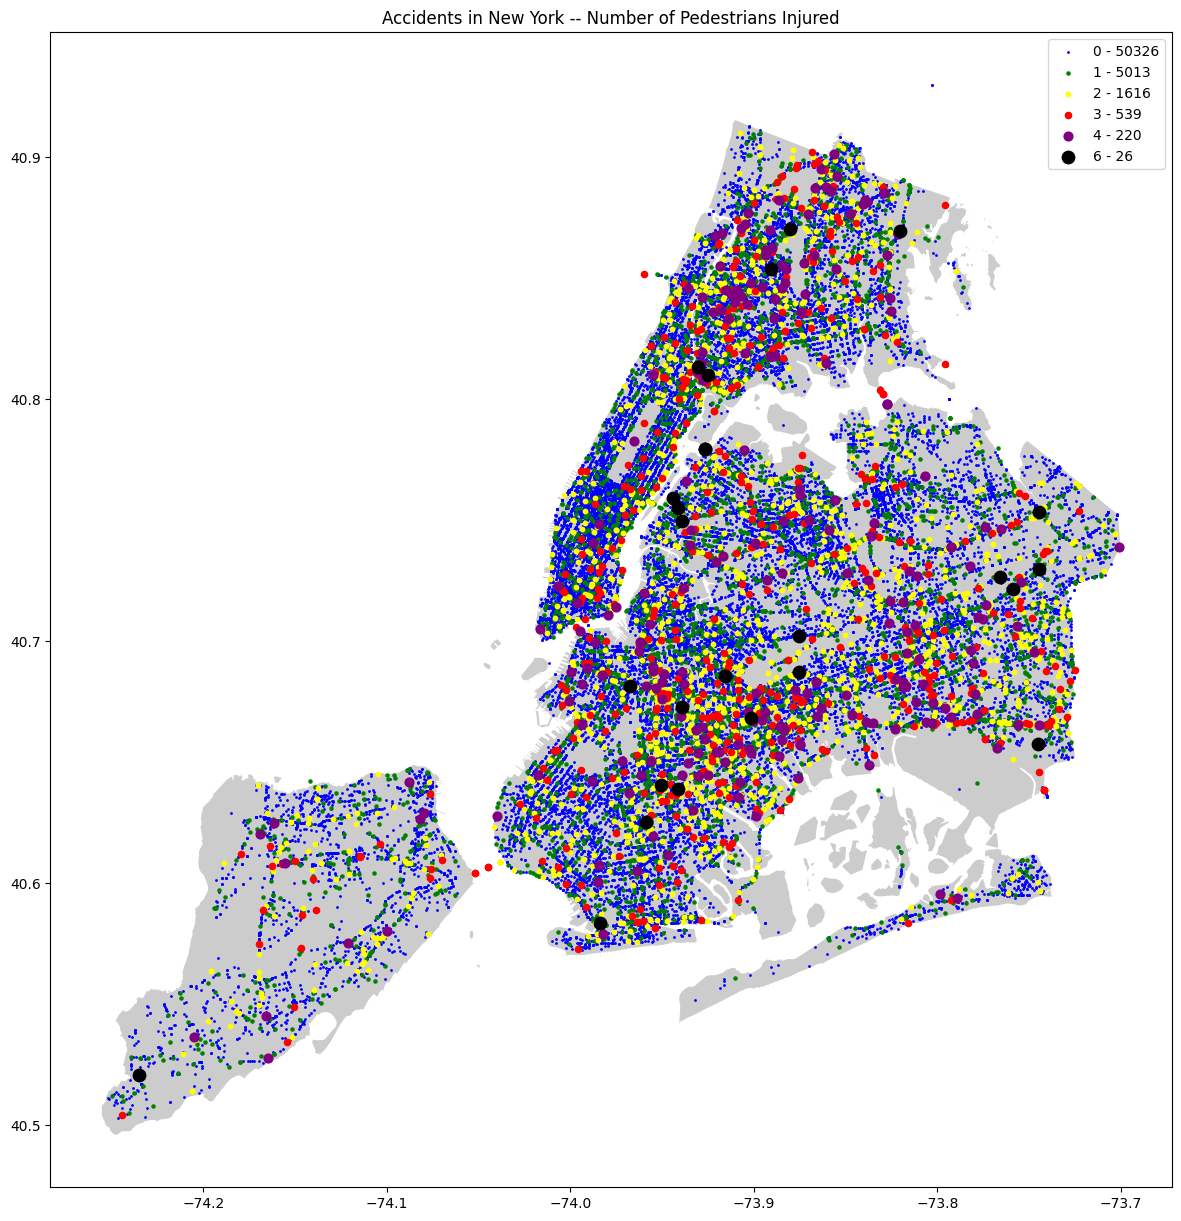

In [62]:
fig, ax = plt.subplots(figsize=(15,15))
boroughs.plot(ax=ax, alpha=0.4, color="grey")
c_name = geo_df[name]
for val, ms, color in [
    (0, 1, "blue"), (1, 5, "green"), (2, 10, "yellow"), (3, 20, "red"), (4, 40, "purple"), (6, 80, "black"),
]:
    label = f"{val} - {injured_hist[val]}"
    geo_df[c_name == val].plot(ax=ax, markersize=ms, color=color, label=label)
ax.set_title("Accidents in New York -- Number of Pedestrians Injured")
plt.legend()

In [58]:
name = "motorist_injured"
injured_hist = mvc_plot[name].value_counts().to_dict()
injured_hist

{0: 50326,
 1: 5013,
 2: 1616,
 3: 539,
 4: 220,
 5: 78,
 6: 26,
 7: 15,
 9: 2,
 21: 1,
 13: 1,
 14: 1,
 15: 1,
 8: 1,
 10: 1}

For "motorist_injured", we only plot up to values of 7.

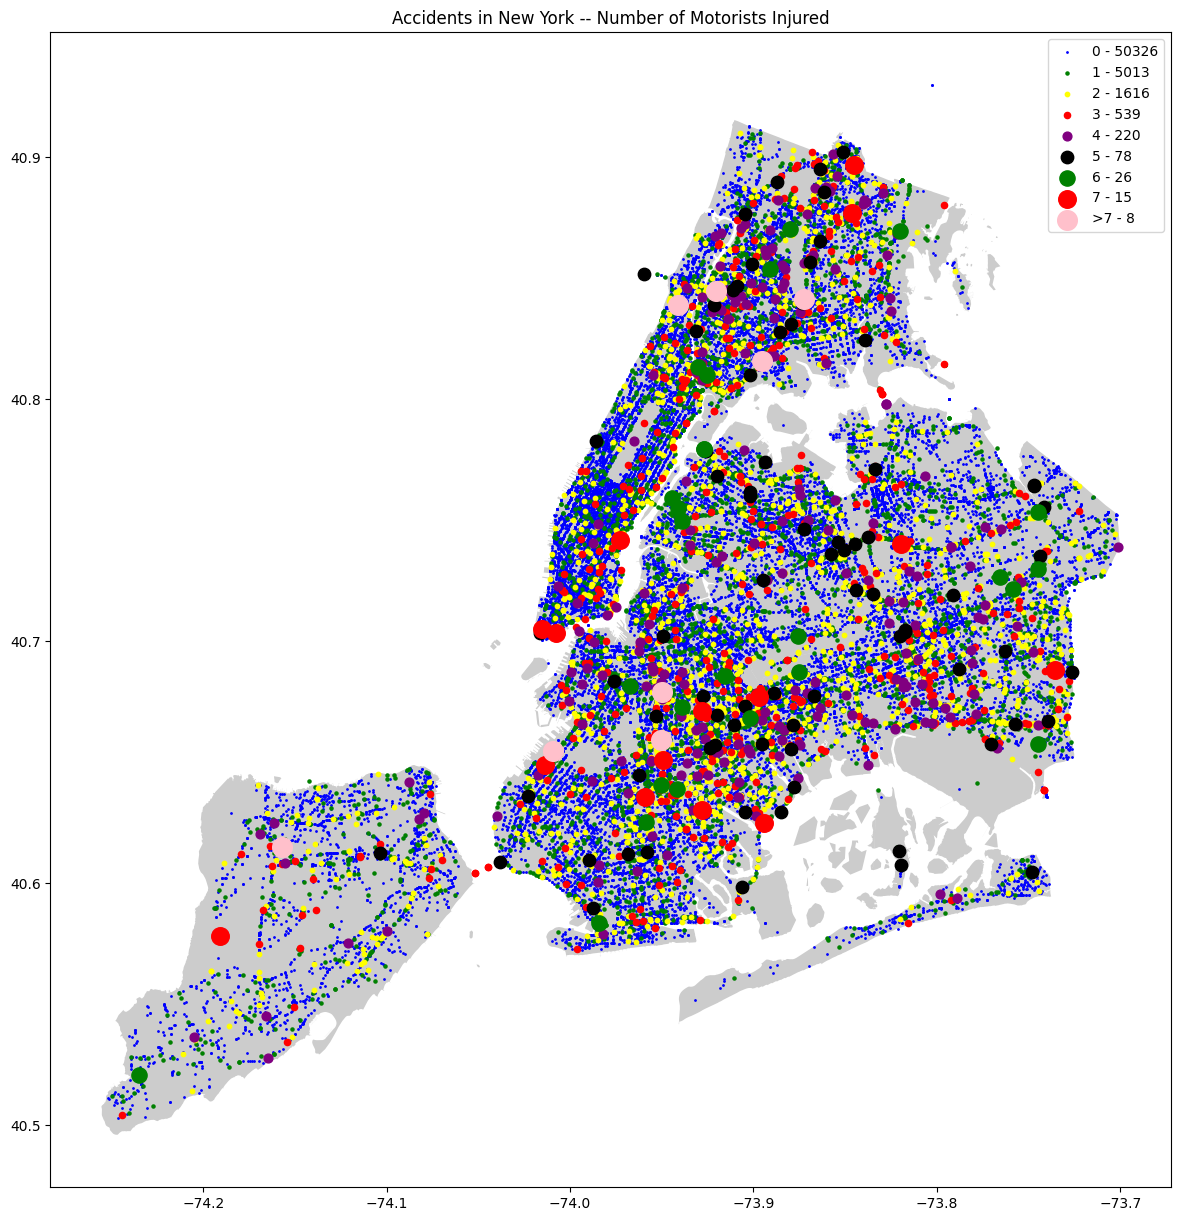

In [63]:
fig, ax = plt.subplots(figsize=(15,15))
boroughs.plot(ax=ax, alpha=0.4, color="grey")
c_name = geo_df[name]
for val, ms, color in [
    (0, 1, "blue"), (1, 5, "green"), (2, 10, "yellow"), (3, 20, "red"), (4, 40, "purple"), (5, 80, "black"),
    (6, 120, "green"), (7, 160, "red"),
]:
    label = f"{val} - {injured_hist[val]}"
    geo_df[c_name == val].plot(ax=ax, markersize=ms, color=color, label=label)

num_gt7 = sum(v for k, v in injured_hist.items() if k > 7)
geo_df[c_name > 7].plot(ax=ax, markersize=200, color="pink", label=f">7 - {num_gt7}")
ax.set_title("Accidents in New York -- Number of Motorists Injured")
plt.legend()